# Neutron spectrum calculations with the `dress` package
*Jacob Eriksson*

## Introduction
The `dress` package is a set of python modules that allow for the calculation of neutron energy spectra from the various fusion reactions. To use it you first need to import it:

In [1]:
import dress

# Basic usage: spectra from point sources
To start calculating spectra, we first need to create an instance of the `Reaction` class, representing the reaction under consideration:

In [2]:
reaction = dress.reactions.DDNHe3Reaction()

Then we create an instance of the `SpectrumCalculator` class, passing the reaction as an argument:

In [3]:
spec_calc = dress.SpectrumCalculator(reaction, n_samples=1e6)

Next we need to draw samples from the reactant velocity distributions. This can be done in any number of ways, as long as the end result is that the `v` attributes of each reactants are both set with `(3,N)` arrays containing `N` samples of the 3 velocity components. Hence, the user is free to write their own sampling routine that provides the velocity arrays of each reactant. For instance, the spectrum from two mono-energetic beams can be simulated as follows:

In [4]:
N = spec_calc.n_samples

va = np.zeros((3,N))
vb = np.zeros((3,N))

va[1] = 1e6             # single velocity, purely in the y-direction (m/s)
vb[2] = 1e6             # single velocity, purely in the z-direction (m/s)

spec_calc.reactant_a.v = va
spec_calc.reactant_b.v = vb

The spectrum is now calculated with a command like this:

In [5]:
spectrum, bin_centers = spec_calc()

Custom bins can be defined by through the keyword arguments `bins` and `bin_edges` (type `help(spec_calc)` for more details).

We can now plot the calculated spectrum to see how it looks.

Text(0, 0.5, 'Spectrum (au)')

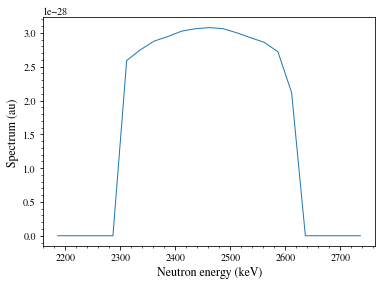

In [6]:
import matplotlib.pyplot as plt

plt.plot(bin_centers, spectrum)
plt.xlabel('Neutron energy (keV)')
plt.ylabel('Spectrum (au)')

We see that this spectrum is centered around 2.5 MeV, as expected for DD neutron emission. The broadening is due to that, by default, the calculated neutron emission is integrated over all emission angles. If we would be interested in the emission in a specific direction, this can controlled with the `u` attribute of the `SpectrumCalculator` object. For instance, if we want to calculate the spectrum emitted in the x-direction we would do the following:

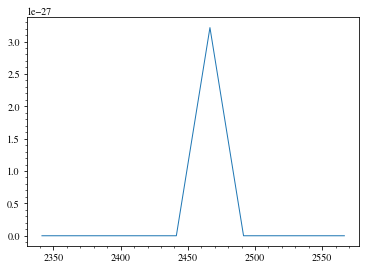

In [7]:
spec_calc.u = [1,0,0]
spectrum, bin_centers = spec_calc()

plt.plot(bin_centers, spectrum)

We see that this results in a mono-energetic neutron emission, as expected for these mono-energetic and mono-directional reactants. The broadening of the above spectrum is purely due to the finite bin width (25 keV by default) used for the histogram.

## Sampling different distributions

In most cases one would like to sample more realistic distributions than the ones used above. To this end, the `dress` framework has a dedicated sub-module called `dists` that allows for the specification of a wide variety of distributions. The `dists` module contains, among others, the following main distribution classes:

* `dists.MaxwellianDistribution`
* `dists.MonoEnergeticDistribution`
* `dists.TabulatedEnergyDistribution`
* `dists.TabulatedEnergyPitchDistribution`
* `dists.TabulatedVparVperpDistribution`

For detailed information about these distribution classes we refer to the respective docstrings. However, all distributions have one thing in common: they all have a method called `sample` that takes the number of samples `N` as input and returns an array of sampled velocities, with shape `(3,N)`. This method can then used to sample reactant velocities. Below we give several examples of how this is done.

**Example 1** If we would like to calculate the spectrum from a Maxwellian population that reacts with a mono-energetic population we could do like this:

Text(0, 0.5, 'Spectrum (au)')

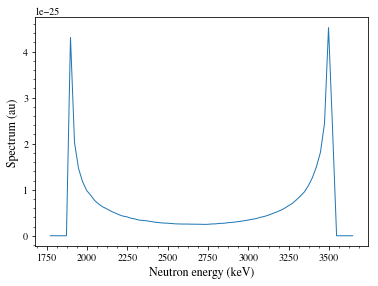

In [8]:
# Distribution of 1st reactant (aka reactant a)
# -----------------------------------------
particle_a = spec_calc.reactant_a.particle
Ta = 5.0              # temperature of reactant a (keV)
dist_a = dress.dists.MaxwellianDistribution(Ta, particle_a)

# Distribution of 2nd reactant (aka reactant b)
# -----------------------------------------
particle_b = spec_calc.reactant_b.particle
Eb = 500.0                 # beam-energy of reactant b(keV)

# For energy distributions we can optionally specify a range of directions of the velocities
# by giving the range of pitch (i.e. v_parallel/v) values relative to some reference direction.
# The reference direction can be the magnetic field in a tokamak, for instance.
# Note that the pitch determines the parallel velocity component completely, while the
# perpendicular component has an additional degree of freedom. In all dress distributions,
# the direction of v_perpendicular is determined by sampling the azimuthal angle w.r.t. to 
# the referense direction uniformly, thus mimicking e.g. the cyclotron motion of charged
# particles around magnetic field lines.
# In the present example we choose the beam to have pitch values close to zero, i.e. mainly 
# perpendicular w.r.t. the reference direction.
dist_b = dress.dists.MonoEnergeticDistribution(Eb, particle_b, pitch_range=[-0.1,0.1], ref_dir=[0,1,0])


# Sample velocities from the distributions
# ----------------------------------------
spec_calc.n_samples = 1e6

spec_calc.reactant_b.v = dist_a.sample(spec_calc.n_samples)
spec_calc.reactant_b.v = dist_b.sample(spec_calc.n_samples)

# Calculate spectrum in a given direction
# ---------------------------------------
spec_calc.u = [0,0,1]       # Tip: try playing with the emission direction to see how this impacts the spectrum
spectrum, bin_centers = spec_calc()

plt.plot(bin_centers, spectrum)
plt.xlabel('Neutron energy (keV)')
plt.ylabel('Spectrum (au)')

If we instead would like to sample one of the reactants from some arbitrary (energy,pitch) distribution we could do like this:

Text(0, 0.5, 'v$_{\\parallel}/v$')

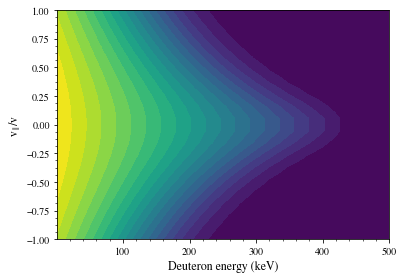

In [9]:
import numpy as np

# Create mock-up (E,p) dist
E_axis = np.linspace(1,500.0,100)    # energy axis (keV)
p_axis = np.linspace(-1.0,1.0,20)    # pitch axis

E0 = 450.0
f_E = 1 - E_axis/E0

delta_p = 3 * np.exp(-E_axis/(E0/3))
delta_p[f_E<0] = 1
f_E[f_E<0] = 0.0
f_p = np.exp(-p_axis[:,None]**2 / delta_p**2)   # use broadcasting to obtain "outer division"

f = np.transpose(f_E * f_p)

plt.contourf(E_axis, p_axis, f.T, 20)
plt.xlabel('Deuteron energy (keV)')
plt.ylabel('v$_{\parallel}/v$')

/home/jeriks/.local/lib/python3.7/site-packages/dress-1.0-py3.7.egg/dress/relkin.py:13: RuntimeWarning: invalid value encountered in sqrt
/home/jeriks/.local/lib/python3.7/site-packages/dress-1.0-py3.7.egg/dress/dists.py:243: RuntimeWarning: invalid value encountered in sqrt
/home/jeriks/.local/lib/python3.7/site-packages/dress-1.0-py3.7.egg/dress/relscatt.py:149: RuntimeWarning: invalid value encountered in greater_equal
/home/jeriks/.local/lib/python3.7/site-packages/dress-1.0-py3.7.egg/dress/relscatt.py:150: RuntimeWarning: invalid value encountered in greater_equal
/home/jeriks/.local/lib/python3.7/site-packages/dress-1.0-py3.7.egg/dress/relscatt.py:201: RuntimeWarning: invalid value encountered in greater
/usr/local/depot/Python-3.7/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/usr/local/depot/Python-3.7/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: Runtime

Text(0, 0.5, 'Spectrum (au)')

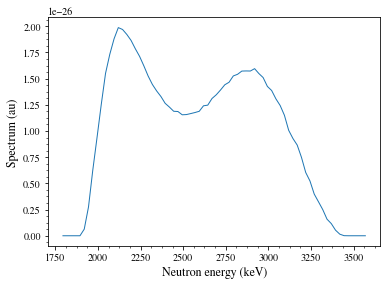

In [10]:
# Now create a tabulated energy-pitch distribution for reactant b from the above data
dist_b = dress.dists.TabulatedEnergyPitchDistribution(E_axis, p_axis, f, particle_b, ref_dir=[0,1,0])

# Sample this dist and compute the spectrum (reactant a is already sampled from teh previous example)
spec_calc.reactant_b.v = dist_b.sample(spec_calc.n_samples)

spectrum, bin_centers = spec_calc()

plt.plot(bin_centers, spectrum)
plt.xlabel('Neutron energy (keV)')
plt.ylabel('Spectrum (au)')

## Spectrum normalization
By default, the calculated spectra are normalized such that the *sum of the spectrum histogram is equal to the reactivity $\left< \sigma v \right>$ per steradian for the reaction under consideration*. Hence, to calculate the DT thermonuclear reactivity at a given temperature we could to the following:

In [11]:
reaction = dress.reactions.DTNHe4Reaction()
spec_calc = dress.SpectrumCalculator(reaction, n_samples=1e6)

T = 10.0     # keV

dist_a = dress.dists.MaxwellianDistribution(T, spec_calc.reactant_a.particle)
dist_b = dress.dists.MaxwellianDistribution(T, spec_calc.reactant_b.particle)

spec_calc.reactant_a.v = dist_a.sample(spec_calc.n_samples)
spec_calc.reactant_b.v = dist_b.sample(spec_calc.n_samples)

spectrum, bin_centers = spec_calc()
σv = 4*np.pi*spectrum.sum()

print(f'DT reactivity @ {T:.1f} keV = {σv:.3e} m³/s')

DT reactivity @ 10.0 keV = 1.138e-22 m³/s


To obtain the neutron emission per unit volume, unit solid angle and unit time from two given fuel ion populations, we would then multiply the above spectrum with the fuel ion densities (and remember to divide by 2 if reactants a and b are sampled from the same distribution).

### Advanced event weighting
If more flexibility is required regarding how the samples are weighted in the calculations, it is possible to manually set the attribute `spec_calc.weights`. Each Monte Carlo reaction event contributes to the neutron sectrum histogram with a weight given by

$$
w_{tot} = w \sigma v
$$

The default is `weights = None`, which effectively means that $w = 1/n_{samples}$ in the above equation, which means that the sum of the spectrum histogram will be an estimate of $\left< \sigma v \right>$, as remarked above.

# Spectra from volume elements
To be written...